<a href="https://colab.research.google.com/github/KaifAhmad1/sentiment-analyzer/blob/main/NEXA_Sentiment_Analysis_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For wordcloud generation (for EDA outside dash)
from wordcloud import WordCloud

# NLTK imports for text preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Sklearn for ML models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# For deep learning model (optional, not integrated into dash below)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Load Dataset
train_path = '/content/drive/MyDrive/Twitter Sentiment Data/twitter_training.csv'
test_path = '/content/drive/MyDrive/Twitter Sentiment Data/twitter_validation.csv'
data = pd.read_csv(train_path)
data.head(25)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
5,2402,Borderlands,Positive,So I spent a few hours making something for fu...
6,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
7,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
8,2402,Borderlands,Positive,So I spent a few hours making something for fu...
9,2402,Borderlands,Positive,2010 So I spent a few hours making something f...


In [9]:
data = pd.read_csv(train_path, header=None)

# Assign descriptive column names based on the expected structure:
data.columns = ['id', 'topic', 'sentiment', 'text']

In [10]:
print("\nData Information:")
data.info()


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   topic      74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [11]:
print("\nStatistical Summary for Numeric Columns:")
print(data.describe())


Statistical Summary for Numeric Columns:
                 id
count  74682.000000
mean    6432.586165
std     3740.427870
min        1.000000
25%     3195.000000
50%     6422.000000
75%     9601.000000
max    13200.000000


In [12]:
print("\nSentiment Distribution:")
print(data['sentiment'].value_counts())


Sentiment Distribution:
sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64


In [13]:
# -------------------------------
# Data Cleaning Function
# -------------------------------
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        return " ".join(tokens)
    return text

In [15]:
nltk.download('punkt_tab')
# Drop rows with missing text and create a clean text column
data = data.dropna(subset=['text'])
data['clean_text'] = data['text'].apply(clean_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [16]:
# Consider only Positive, Negative, and Neutral sentiments (drop others, e.g., 'Irrelevant')
data_ml = data[data['sentiment'].isin(['Positive', 'Negative', 'Neutral'])].copy()

In [17]:
# Create a simulated date column (for sentiment trend analysis)
data_ml['date'] = pd.date_range(start='2021-01-01', periods=len(data_ml), freq='h')

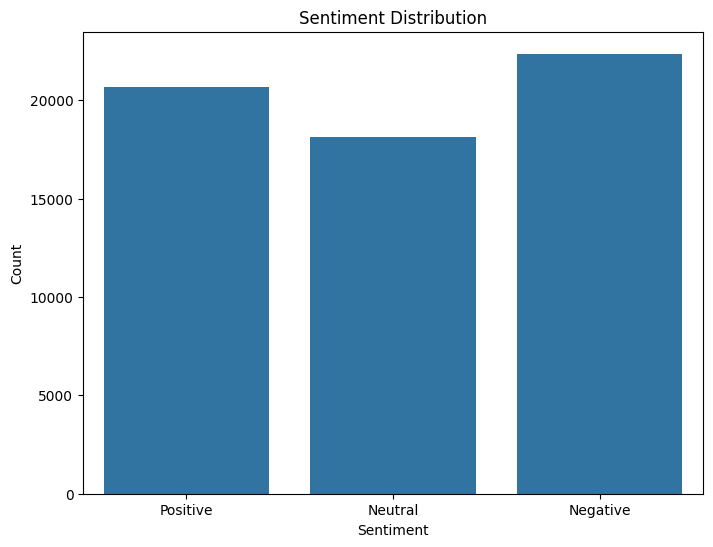

In [18]:
# =============================================
# STEP 2: EXPLORATORY DATA ANALYSIS (EDA)
# =============================================

# 1. Sentiment Distribution Plot
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=data_ml, order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

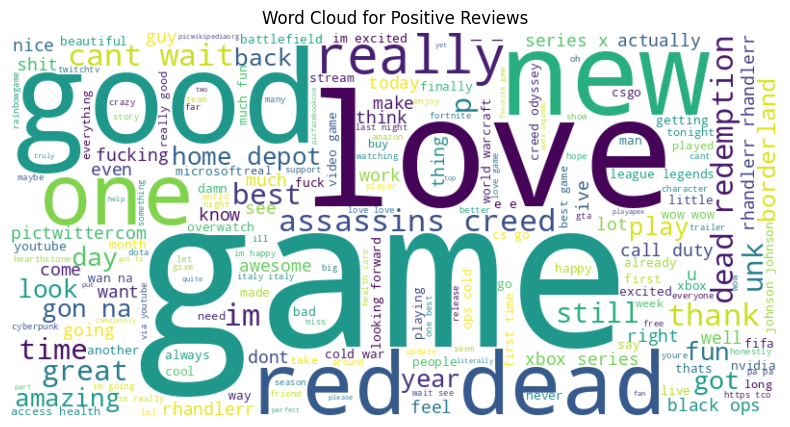

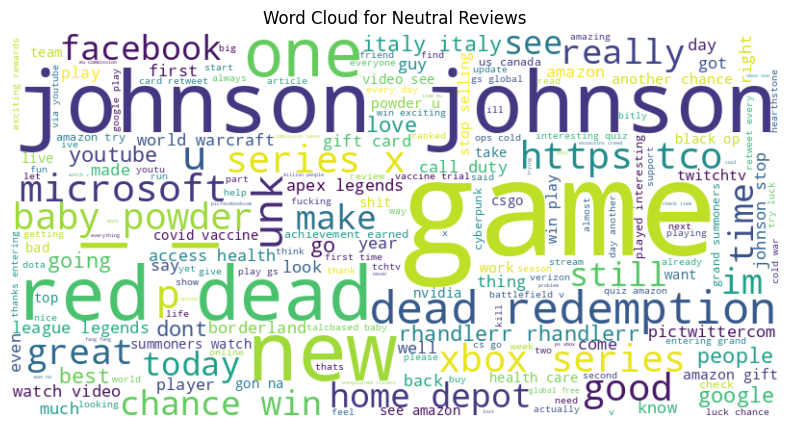

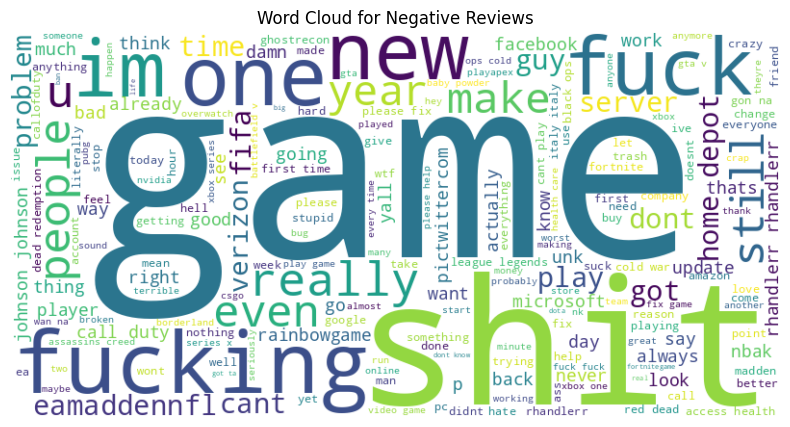

In [19]:
# 2. Word Clouds for each sentiment category
sentiments = ['Positive', 'Neutral', 'Negative']
for sentiment in sentiments:
    text_data = " ".join(data_ml[data_ml['sentiment'] == sentiment]['clean_text'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {sentiment} Reviews")
    plt.axis('off')
    plt.show()

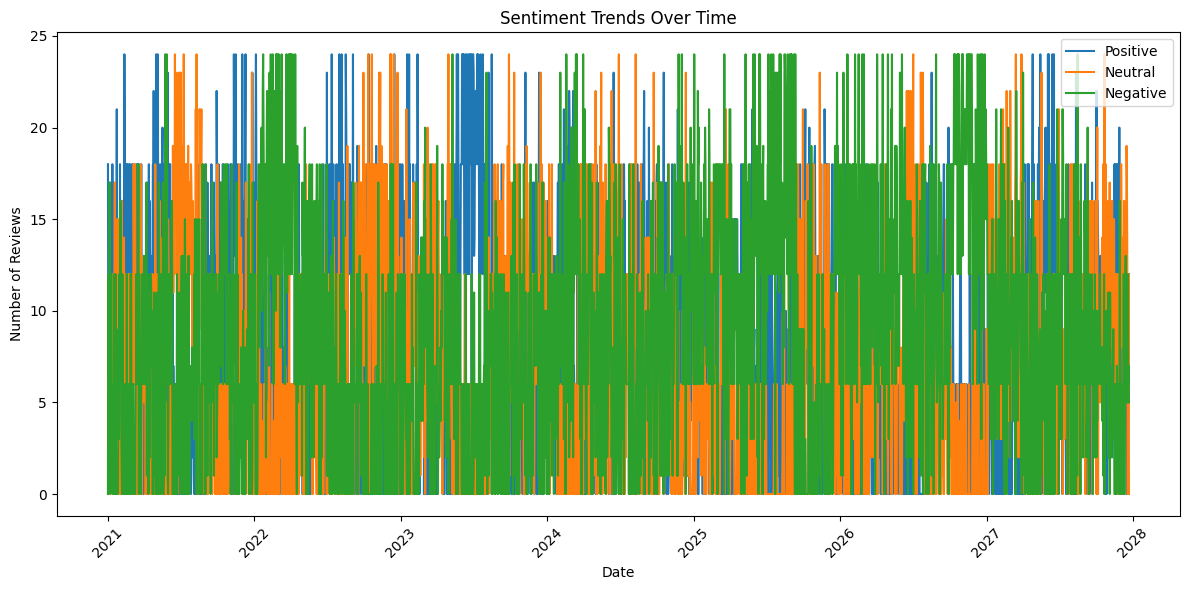

In [20]:
# 3. Sentiment Trends Over Time (using the simulated date column)
# First, group by date (e.g., daily sentiment counts)
data_ml['day'] = data_ml['date'].dt.date
sentiment_trends = data_ml.groupby(['day', 'sentiment']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
for sentiment in ['Positive', 'Neutral', 'Negative']:
    plt.plot(sentiment_trends.index, sentiment_trends[sentiment], label=sentiment)
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.title('Sentiment Trends Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# =============================================
# STEP 3A: MACHINE LEARNING MODEL DEVELOPMENT (Logistic Regression)
# =============================================

# Prepare data for classical ML
X = data_ml['clean_text']
y = data_ml['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Predictions and evaluation
y_pred_lr = lr_model.predict(X_test_tfidf)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.81      0.80      4427
     Neutral       0.71      0.69      0.70      3678
    Positive       0.76      0.76      0.76      4120

    accuracy                           0.75     12225
   macro avg       0.75      0.75      0.75     12225
weighted avg       0.75      0.75      0.75     12225

Logistic Regression Accuracy: 0.7539468302658486


In [22]:
# =============================================
# STEP 3B: DEEP LEARNING MODEL DEVELOPMENT (LSTM)
# =============================================

# For the LSTM model, we use a Tokenizer to vectorize text and pad sequences.
max_words = 5000  # Vocabulary size
max_len = 100     # Maximum review length

# Tokenize the clean text
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences so that they have equal length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Encode labels to integers (e.g., using pandas factorize)
label_mapping, y_train_encoded = pd.factorize(y_train)
_, y_test_encoded = pd.factorize(y_test)

# Convert labels to categorical for Keras
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

# Build the LSTM model
embedding_dim = 64

lstm_model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dense(y_train_cat.shape[1], activation='softmax')
])

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

# Train the LSTM model
history = lstm_model.fit(X_train_pad, y_train_cat,
                         epochs=5,
                         batch_size=128,
                         validation_split=0.2,
                         verbose=1)

# Evaluate on test set
loss, accuracy = lstm_model.evaluate(X_test_pad, y_test_cat, verbose=0)
print("\nLSTM Model Accuracy:", accuracy)

ValueError: invalid literal for int() with base 10: 'Negative'